# 1. Introduction

## About the problem
The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

Last year, in the Toxic Comment Classification Challenge, you built multi-headed models to recognize toxicity and several subtypes of toxicity. This year's competition is a related challenge: building toxicity models that operate fairly across a diverse range of conversations.







## Previous competition and it's problem
Here’s the background: When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

In this competition, you're challenged to build a model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. You'll be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias. Develop strategies to reduce unintended bias in machine learning models, and you'll help the Conversation AI team, and the entire industry, build models that work well for a wide range of conversations.

## To understand more on bias
https://www.youtube.com/watch?v=59bMh59JQDo

## Understanding the evalution metrics
https://medium.com/jash-data-sciences/measuring-unintended-bias-in-text-classification-a1d2e6630742

**a. Subgroup AUC** — This calculates AUC on only the examples from the subgroup. It represents model understanding and performance within the group itself.
A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.

**b. BNSP AUC** — This calculates AUC on the positive examples from the background and the negative examples from the subgroup.
A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not.


**c. BPSN AUC** — This calculates AUC on the negative examples from the background and the positive examples from the subgroup.
A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not.

**d. Final Metrics** — We combine the overall AUC with the generalized mean of the Bias AUCs to calculate the final model score:

score=w0AUCoverall+∑a=1AwaMp(ms,a)
where:

A = number of submetrics (3)

ms,a = bias metric for identity subgroup s using submetric a

wa = a weighting for the relative importance of each submetric; all four w values set to 0.25


In [0]:
# About the problem

# What was the problem in the previous competition - the human bias issue
# google video - explaning the bias pat
# How this competiton is evaluated and the metrics explanation

# 2. Using Kaggle token to download the data and process it over cloud

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nihal24","key":"b78efd274d0400e52a3b3ad9592cf463"}'}

In [0]:
def get_data():
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -p /content
  !unzip \*.zip

In [0]:
get_data()

 99% 269M/273M [00:02<00:00, 93.5MB/s]
100% 273M/273M [00:02<00:00, 105MB/s] 
 42% 5.00M/12.0M [00:00<00:00, 46.9MB/s]
100% 12.0M/12.0M [00:00<00:00, 76.4MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 82.4MB/s]
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

3 archives were successfully processed.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


# 3. Imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tqdm import tqdm
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report
%matplotlib inline
warnings.filterwarnings("ignore")
from IPython.display import Image,YouTubeVideo,HTML

#KERAS Import
from keras.models import Sequential, Model
from keras.utils import to_categorical,plot_model
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.initializers import he_normal
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Embedding, LSTM, GRU, Flatten, Input, concatenate, Conv1D, GlobalMaxPool1D, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GlobalAveragePooling1D, add
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.initializers import Orthogonal
from keras.preprocessing.text import one_hot
from keras.constraints import max_norm
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

#for attention mechanism
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
df = pd.read_csv('train.csv')
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [0]:
test_df = pd.read_csv('test.csv')

# 4. Data cleaning

In [0]:
print(df.iloc[28]['comment_text'])
print("Toxicity Level: ",df.iloc[28]['target'])

Thanks! We're really going to try — not only to improve civility, but also to make comments more dynamic and interesting.
Toxicity Level:  0.0


In [0]:
print(df.iloc[4]['comment_text'])
print("Toxicity Level: ",df.iloc[4]['target'])

haha you guys are a bunch of losers.
Toxicity Level:  0.8936170212765957


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Combining all the above statemennts 
preprocessed_comments = []
# tqdm is for printing the status bar
for sentence in tqdm(df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() )
    preprocessed_comments.append(sent.lower().strip())

100%|██████████| 1804874/1804874 [01:06<00:00, 26958.60it/s]


In [0]:
if e not in stopwords

In [0]:
df['comment_text'] = preprocessed_comments

In [0]:
df['comment_text'][1]

'thank you this would make my life a lot less anxiety inducing keep it up and do not let anyone get in your way'

In [0]:
# Combining all the above statemennts 
preprocessed_comments_test = []
# tqdm is for printing the status bar
for sentence in tqdm(test_df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split())
    preprocessed_comments_test.append(sent.lower().strip())

100%|██████████| 97320/97320 [00:03<00:00, 27637.70it/s]


In [0]:
test_df['comment_text'] = preprocessed_comments_test

# 5. Exploratory Data Analysis

## Percentage of NaN values

In [0]:
train_len = len(df.index)

In [0]:
miss_val_train_df = df.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino                                 77.553558
male                                   77.553558
muslim                                 77.553558
other_disability                       77.553558
other_gender                           77.553558
other_race_or_ethnicity                77.553558
other_religion                         77.553558
other_sexual_orientation               77.553558
physical_disability 

## Distribution Plots

In [0]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        # This will find all the values which are not null so as to plot the ditribution
        sns.distplot(df.loc[~df[feature].isnull(),feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

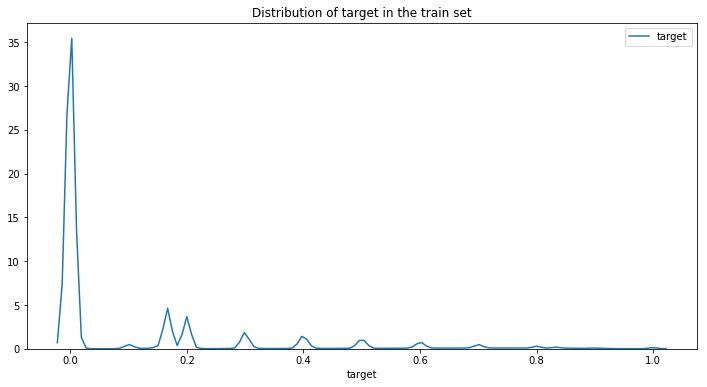

In [0]:
# Distribution of target variable
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(df['target'],kde=True,hist=False, bins=120, label='target')
plt.legend()
plt.show()

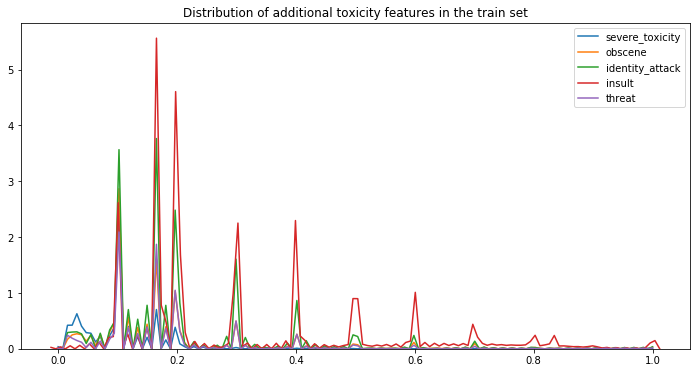

In [0]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

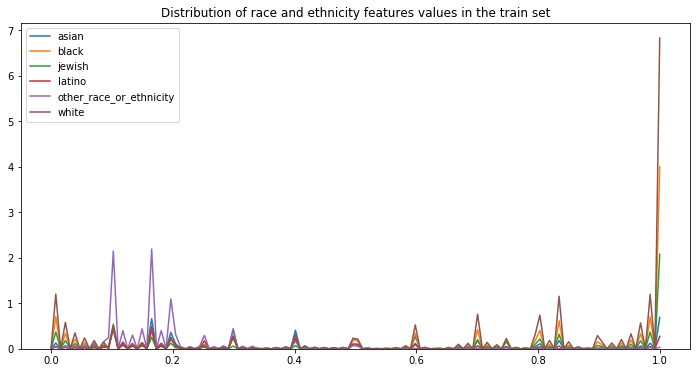

In [0]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set")

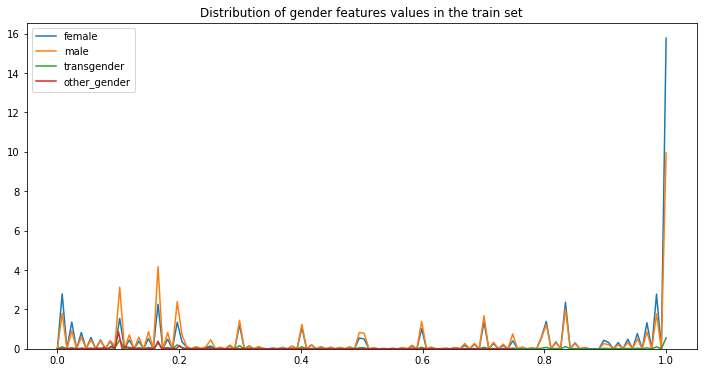

In [0]:
features = ['female', 'male', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender features values in the train set")

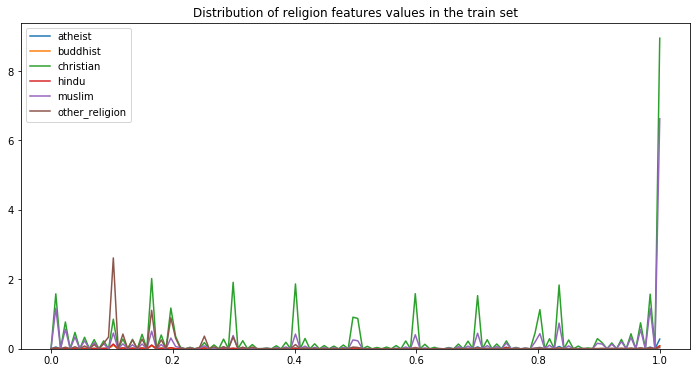

In [0]:
features = ['atheist','buddhist','christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

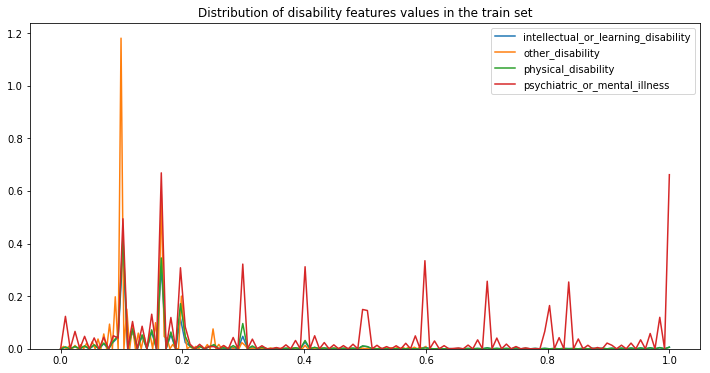

In [0]:
features = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
plot_features_distribution(features, "Distribution of disability features values in the train set")

1. Looks like they are lot of values where the target value is 0 and fewer values near to 1.We have to note that values which are less that 0.5 are non- toxic and greater than 0.5 are toxic
2. We see a lot of "Female" associated word
3. We see that religions like "Muslim" and "Christanity" are on the higher numbers

## Word Cloud - This is to see what are the frequent words using for different categories

In [0]:
def make_wordcloud(comment_words,title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
              min_font_size = 10,random_state=101,repeat=True).generate(str(comment_words)) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(title)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

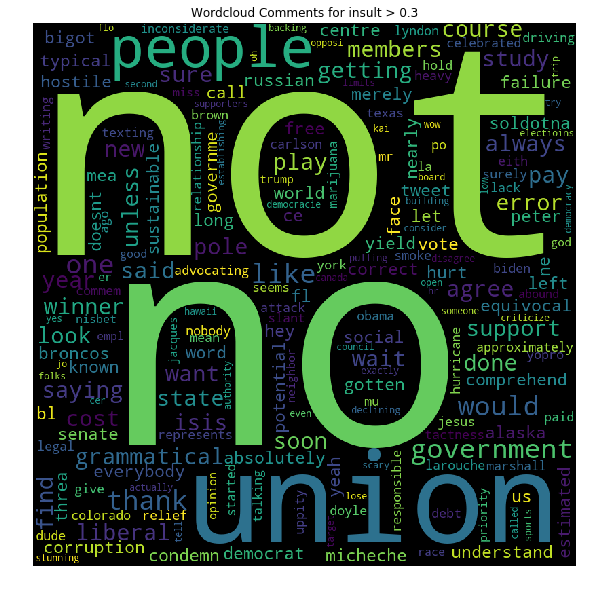

In [0]:
make_wordcloud(df.loc[df['insult'] < 0.3]['comment_text'].sample(10000),title='Wordcloud Comments for insult > 0.3')

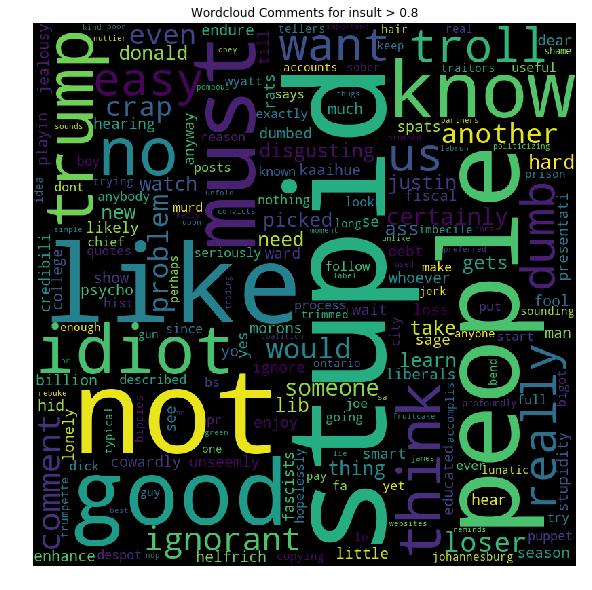

In [0]:
make_wordcloud(df.loc[df['insult'] > 0.8]['comment_text'].sample(10000),title='Wordcloud Comments for insult > 0.8')

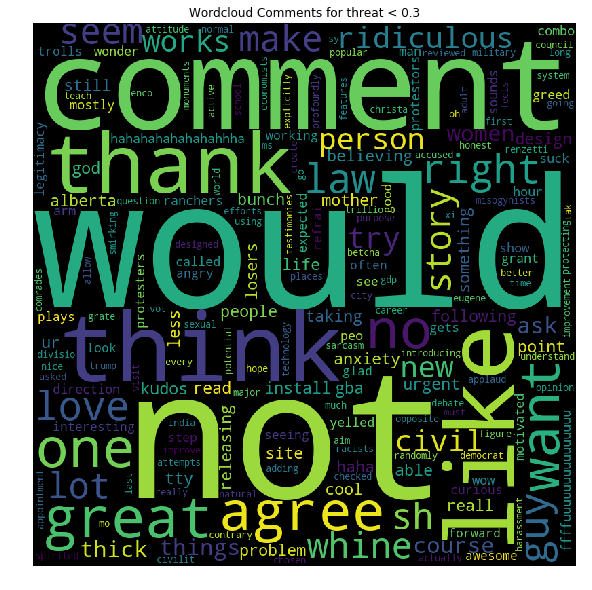

In [0]:
make_wordcloud(df.loc[df['threat'] < 0.3]['comment_text'],title='Wordcloud Comments for threat < 0.3')

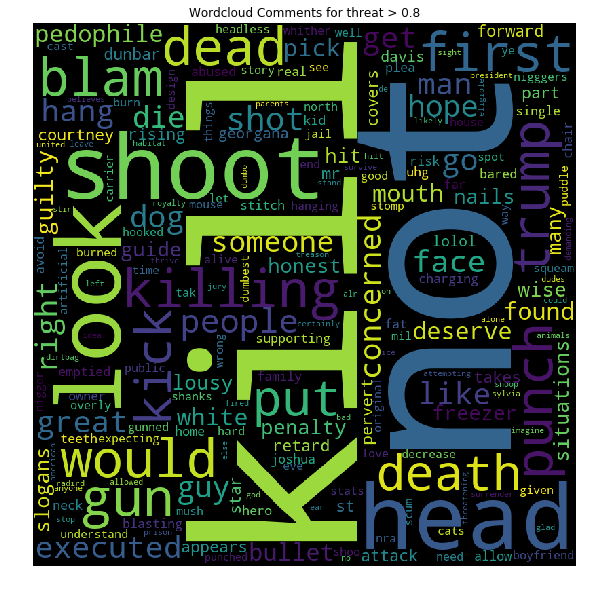

In [0]:
make_wordcloud(df.loc[df['threat'] > 0.8]['comment_text'],title='Wordcloud Comments for threat > 0.8')

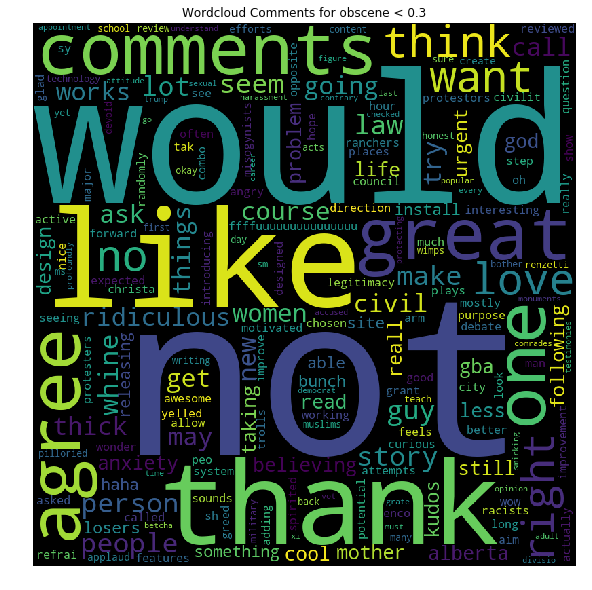

In [0]:
make_wordcloud(df.loc[df['obscene'] < 0.3]['comment_text'],title='Wordcloud Comments for obscene < 0.3')

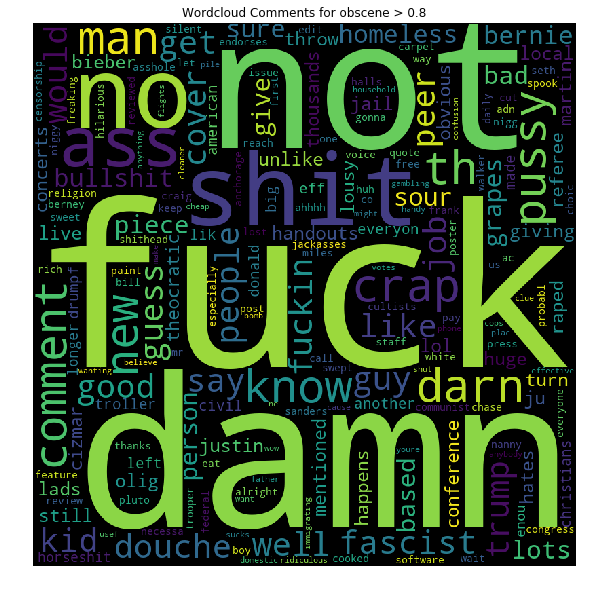

In [0]:
make_wordcloud(df.loc[df['obscene'] > 0.8]['comment_text'],title='Wordcloud Comments for obscene > 0.8')

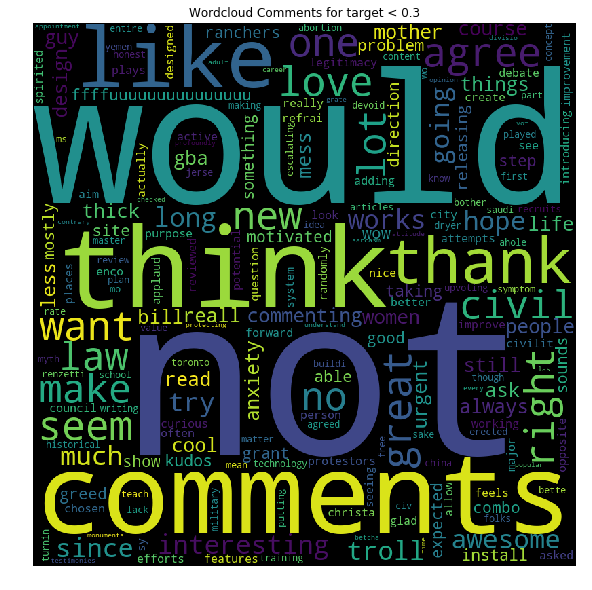

In [0]:
make_wordcloud(df.loc[df['target'] < 0.3]['comment_text'],title='Wordcloud Comments for target < 0.3')

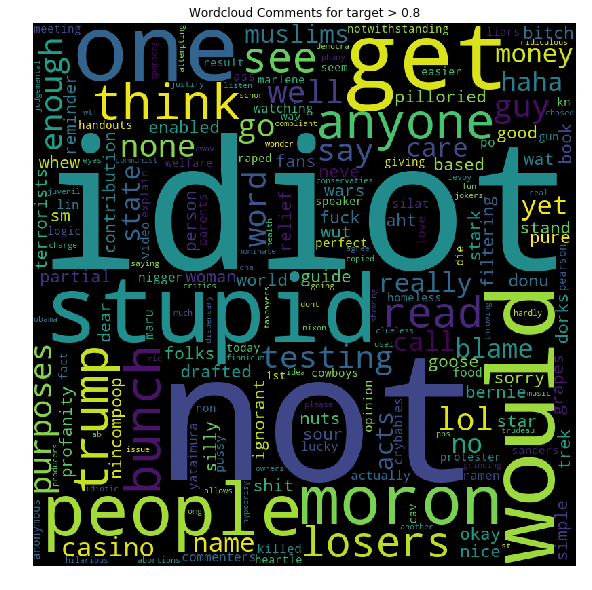

In [0]:
make_wordcloud(df.loc[df['target'] > 0.8]['comment_text'],title='Wordcloud Comments for target > 0.8')

# 6. Data Preprocessing

In [0]:
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [0]:
for column in identity_columns + ['target']:
    df[column] = np.where(df[column] >= 0.5, True, False)

In [0]:
# Target variable as well
y = df['target'].values

In [0]:
# We will use tfidf and w2v to vectorize the words

In [0]:
train_df, cv_df, y_train, y_cv = train_test_split(df, y, test_size=0.2, random_state=42)

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [0]:
train_tfidf = vectorizer.fit_transform(train_df["comment_text"])
cv_tfidf = vectorizer.transform(cv_df["comment_text"])
test_tfidf = vectorizer.transform(test_df["comment_text"])

In [0]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix,index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [0]:
# Code help from Slack channel
def threshold_based_prediction(proba,threshold,tpr,fpr):
    thres = threshold[np.argmax(fpr*(1-tpr))]
    predictions = []
    for i in proba:
        if i>=thres:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# 7. Baseline - Logistic Regression model

### Using TFIDF vectorized data

In [0]:
alpha = [10 ** x for x in range(-5, 2)]
auc_array_train=[]
auc_array_cv=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=5,class_weight='balanced')
  clf.fit(train_tfidf, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(train_tfidf, y_train)
    
    
  predict_y_train = sig_clf.predict_proba(train_tfidf)[:,1]
  predict_y = sig_clf.predict_proba(cv_tfidf)[:,1]
  auc_array_train.append(roc_auc_score(y_train, predict_y_train))
  auc_array_cv.append(roc_auc_score(y_cv, predict_y))
  print('For values of alpha = ', i, "The auc score on CV is:",roc_auc_score(y_cv, predict_y))

For values of alpha =  1e-05 The auc score on CV is: 0.9363977807167901
For values of alpha =  0.0001 The auc score on CV is: 0.8998879161166482
For values of alpha =  0.001 The auc score on CV is: 0.8676216784850541
For values of alpha =  0.01 The auc score on CV is: 0.8613708752811944
For values of alpha =  0.1 The auc score on CV is: 0.8612331264756222
For values of alpha =  1 The auc score on CV is: 0.86030901771031
For values of alpha =  10 The auc score on CV is: 0.8598534496997849


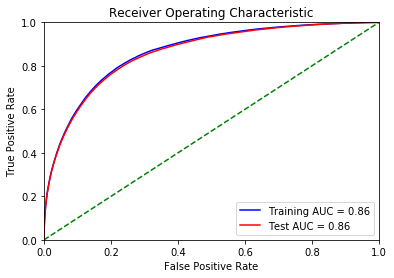

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr_train, tpr_train, threshold_train = roc_curve(y_train, predict_y_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_cv, predict_y)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


plt.title('Receiver Operating Characteristic')

plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'r', label = 'Test AUC = %0.2f' % roc_auc_test)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
clf = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                     

### Results

In [0]:
predtrain = sig_clf.predict_proba(train_tfidf)[:,1]
predcv = sig_clf.predict_proba(cv_tfidf)[:,1]
pred = sig_clf.predict_proba(test_tfidf)[:,1]

	TRAIN DATA CONFUSION MATRIX


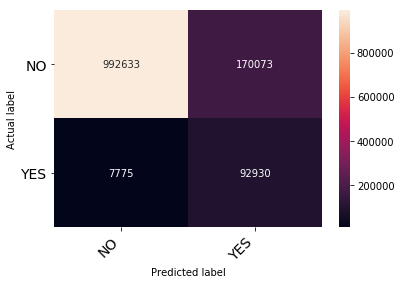

In [0]:
predtrain = threshold_based_prediction(predtrain,threshold_train,tpr_train,fpr_train)
cm = confusion_matrix(y_train, predtrain)
print("\tTRAIN DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

	TEST DATA CONFUSION MATRIX


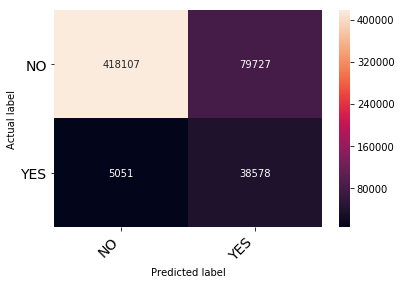

In [0]:
predcv = threshold_based_prediction(predcv,threshold_test,tpr_test,fpr_test)
cm = confusion_matrix(y_cv, predcv)
print("\tTEST DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

### AUC scores

In [0]:
auc = roc_auc_score(y_train, predtrain)
print('\nTRAIN AUC on CV data is %f' % (auc))


TRAIN AUC on CV data is 0.955492


In [0]:
auc = roc_auc_score(y_cv, predcv)
print('\nTEST AUC on CV data is %f' % (auc))


TEST AUC on CV data is 0.862040


### F1 Score

In [0]:
print(classification_report(y_cv,predcv))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    497834
           1       0.33      0.88      0.48     43629

    accuracy                           0.84    541463
   macro avg       0.66      0.86      0.69    541463
weighted avg       0.93      0.84      0.87    541463



### Conclusion
1. With Logistic regression we are seeing that the model is slightly overfitting on the train data
2. It is not doing very good against the unintended bias that we are trying to avoid
3. A lot of comments that are usually not toxic has been classified as toxic by our model by looking at the confusion matrix
4. From the f1 sore as well, we can make out the same info

# 8. Recurrent Neural Network

### Metrics definition

In [0]:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/90986#latest-527331
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive
TOXICITY_COLUMN = 'target'

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [0]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [0]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

### Using Convolutional Neural Net for classifying toxic comments

#### Preparing the text data for model

In [0]:
MAX_VOCAB_SIZE = 100000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'
MAX_SEQUENCE_LENGTH = 300

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
def padding_text(texts, tokenizer):
    return sequence.pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
train_text = padding_text(train_df[TEXT_COLUMN], tokenizer)
train_y = to_categorical(train_df[TOXICITY_COLUMN])
validate_text = padding_text(cv_df[TEXT_COLUMN], tokenizer)
validate_y = to_categorical(cv_df[TOXICITY_COLUMN])

In [0]:
# for submission purpose
test_text = padding_text(test_df[TEXT_COLUMN], tokenizer)

In [0]:
NUM_EPOCHS = 10
BATCH_SIZE = 512

In [0]:
# https://fasttext.cc/docs/en/english-vectors.html
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2019-09-17 10:38:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  30.1MB/s    in 49s     

2019-09-17 10:39:28 (29.7 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [0]:
!unzip crawl*.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


#### Creating the embedding matrix for the embedding layer

In [0]:
embeddings_index = {}
with open('crawl-300d-2M.vec' ,encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [0]:
len(tokenizer.word_index)

276262

In [0]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,300))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    num_words_in_embedding += 1
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(276263, 300)

#### Model building and training

In [0]:
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
x = embedding_layer(input_text)
x = Conv1D(128, 2, activation='relu', padding='same')(x)
x = MaxPooling1D(5, padding='same')(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(5, padding='same')(x)
x = Conv1D(128, 4, activation='relu', padding='same')(x)
x = MaxPooling1D(40, padding='same')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

W0821 12:16:58.254515 140340682626944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 12:16:58.279332 140340682626944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 12:16:58.283469 140340682626944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 12:16:58.293708 140340682626944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0821 12:16:58.294833 1403406826

#### Model visualization

In [0]:
model = Model(inputs=[input_text], outputs=[output])

In [0]:
plot_model(model, show_shapes=True, to_file='model.png')

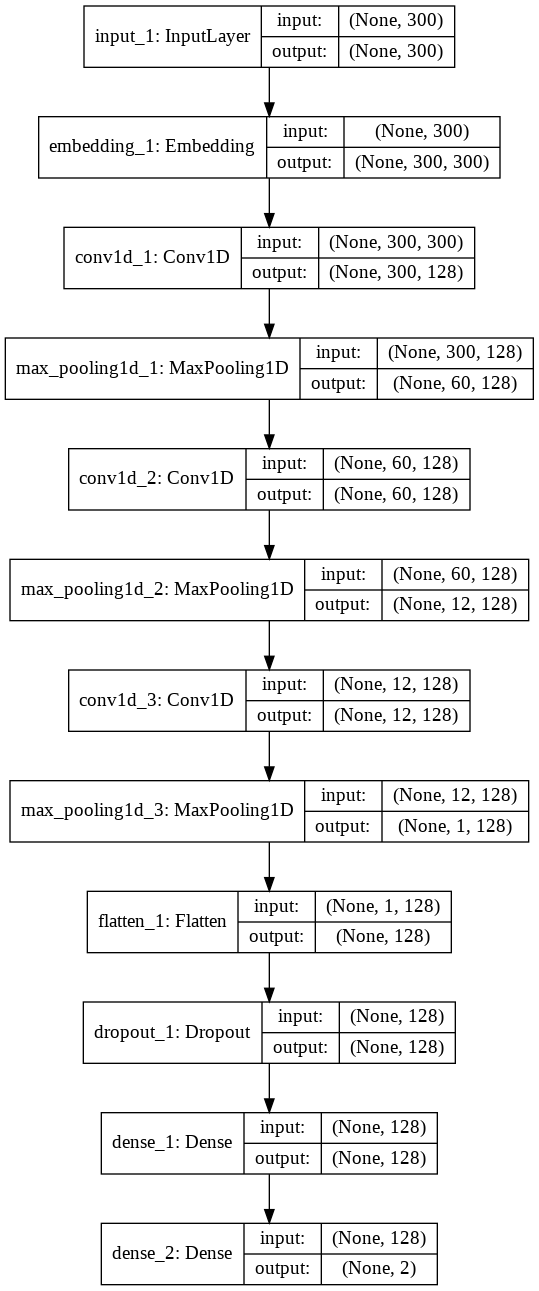

In [0]:
Image(filename="model.png")

In [0]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

W0821 12:17:02.089591 140340682626944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
CNN_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y))

W0821 12:17:06.941819 140340682626944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1263411 samples, validate on 541463 samples
Epoch 1/10
1263411/1263411 [==============================] - 119s 94us/step - loss: 0.1442 - acc: 0.9449 - val_loss: 0.1334 - val_acc: 0.9488
Epoch 2/10
1263411/1263411 [==============================] - 118s 94us/step - loss: 0.1254 - acc: 0.9502 - val_loss: 0.1351 - val_acc: 0.9440
Epoch 3/10
1263411/1263411 [==============================] - 118s 94us/step - loss: 0.1200 - acc: 0.9518 - val_loss: 0.1279 - val_acc: 0.9494
Epoch 4/10
1263411/1263411 [==============================] - 118s 94us/step - loss: 0.1153 - acc: 0.9530 - val_loss: 0.1310 - val_acc: 0.9479
Epoch 5/10
1263411/1263411 [==============================] - 118s 94us/step - loss: 0.1111 - acc: 0.9542 - val_loss: 0.1303 - val_acc: 0.9490
Epoch 6/10
1263411/1263411 [==============================] - 118s 94us/step - loss: 0.1071 - acc: 0.9552 - val_loss: 0.1382 - val_acc: 0.9482
Epoch 7/10
1263411/1263411 [==============================] - 118s 94us/step - loss: 0.10

#### Results

In [0]:
# Prediction on CV data
MODEL_NAME = 'cnn_model'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

In [0]:
cv_df.head(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,cnn_model
286892,593336,False,what breathe fresh air someone embraces common...,0.0,0.0,0.0,0.166667,0.0,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2016-11-11 17:46:40.531665+00,54,NaN,151356,approved,0,0,0,4,0,0.0,0,6,0.000038
419218,756192,True,your jewish friends ones told zionists control...,0.2,0.0,0.6,0.400000,0.0,0.0,0.0,0.0,False,0.0,False,False,0.0,0.0,False,0.0,True,0.0,False,False,0.0,0.166667,0.0,0.0,0.0,0.0,False,0.0,True,2016-12-26 15:45:07.874526+00,54,754943.0,158493,approved,0,0,0,0,0,0.0,6,10,0.147841
1055330,5407051,False,possible collusion trump affiliates not debunk...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,False,NaN,False,False,NaN,NaN,False,NaN,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,2017-06-13 16:05:45.932626+00,13,NaN,343435,approved,0,0,0,1,0,0.0,0,4,0.000037


In [0]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.963108,0.789993,homosexual_gay_or_lesbian,0.804927,3339
6,0.956750,0.807953,black,0.813444,4402
7,0.959715,0.808311,white,0.819411,7450
5,0.952778,0.829326,muslim,0.822012,6379
4,0.946096,0.874386,jewish,0.862400,2315
8,0.957525,0.866619,psychiatric_or_mental_illness,0.887152,1511
1,0.947219,0.900749,female,0.898675,16043
0,0.953743,0.893734,male,0.901303,13383
3,0.930702,0.926294,christian,0.904394,12194


In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.8992199831578233

#### Conclusion
1. Although we are getting good accuracy, our model is able to give good score for the four metrics designed. We will try sample weight on this model and see if the performance improves
2. We can try to get better results if we try LSTM or GRU. Lets try that
3. We are getting a good score of 0.8992199831578233

### Using LSTM - Single LSTM layer architecture

#### Model building

In [0]:
input_text_lstm = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer_lstm = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
l = embedding_layer_lstm(input_text_lstm)
l = LSTM(128,return_sequences=True,dropout=0.5,kernel_regularizer=l2(0.001))(l)
l = Flatten()(l)
l = Dropout(0.5)(l)
l = Dense(128, activation='relu')(l)
lstm_output = Dense(2, activation='softmax')(l)

In [0]:
model = Model(inputs=[input_text_lstm], outputs=[lstm_output])

#### Model visualization

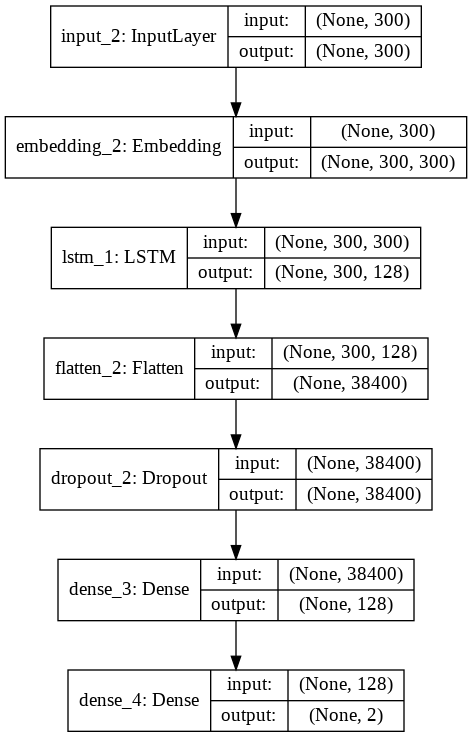

In [0]:
plot_model(model, show_shapes=True, to_file='singlelstm.png')
Image(filename="singlelstm.png")

#### Model training

In [0]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [0]:
SLSTM_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y))

Train on 1263411 samples, validate on 541463 samples
Epoch 1/10
1263411/1263411 [==============================] - 1870s 1ms/step - loss: 0.1998 - acc: 0.9347 - val_loss: 0.1620 - val_acc: 0.9432
Epoch 2/10
1263411/1263411 [==============================] - 1875s 1ms/step - loss: 0.1750 - acc: 0.9393 - val_loss: 0.1584 - val_acc: 0.9439
Epoch 3/10
1263411/1263411 [==============================] - 1873s 1ms/step - loss: 0.1708 - acc: 0.9405 - val_loss: 0.1599 - val_acc: 0.9426
Epoch 4/10
1263411/1263411 [==============================] - 1877s 1ms/step - loss: 0.1682 - acc: 0.9410 - val_loss: 0.1557 - val_acc: 0.9449
Epoch 5/10
1263411/1263411 [==============================] - 1872s 1ms/step - loss: 0.1664 - acc: 0.9415 - val_loss: 0.1541 - val_acc: 0.9456
Epoch 6/10
1263411/1263411 [==============================] - 1874s 1ms/step - loss: 0.1646 - acc: 0.9420 - val_loss: 0.1528 - val_acc: 0.9452
Epoch 7/10
1263411/1263411 [==============================] - 1881s 1ms/step - loss: 0.16

#### Results

In [0]:
# Prediction on CV data
MODEL_NAME = 'slstm_model'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

In [0]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.955710,0.793339,homosexual_gay_or_lesbian,0.796801,3339
6,0.955069,0.807608,black,0.809340,4402
7,0.955583,0.811312,white,0.818645,7450
5,0.949681,0.834016,muslim,0.822300,6379
4,0.953174,0.858770,jewish,0.864352,2315
8,0.919003,0.918279,psychiatric_or_mental_illness,0.870301,1511
0,0.949219,0.892721,male,0.892510,13383
1,0.944829,0.905491,female,0.899125,16043
3,0.928312,0.935355,christian,0.912746,12194


In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.8982272880613014

#### Conclusion
1. We are getting slightly better results on the 3 designed metrics to our CNN1D architecture with just a single LSTM layer.
2. We can do better using Bi-directional LSTM layer and giving sample weights to identity columns
3. We are getting a good score of 0.8982272880613014

## Using LSTM - Birectional LSTM and sample weights

In [0]:
#Refer : https://datascience.stackexchange.com/questions/31129/sample-importance-training-weights-in-keras

### Model building

In [0]:
input_text_blstm = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer_blstm = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
b = embedding_layer_blstm(input_text_blstm)
b = SpatialDropout1D(0.2)(b)
b = Bidirectional(LSTM(128, return_sequences=True))(b)
b = Bidirectional(LSTM(128, return_sequences=True))(b)
b = GlobalMaxPooling1D()(b)
b = Dense(512, activation='relu')(b)
b = Dense(512, activation='relu')(b)
blstm_output = Dense(2, activation='softmax')(b)

W0827 02:36:33.446703 140514143192960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 02:36:33.503952 140514143192960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 02:36:33.512784 140514143192960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 02:36:33.523778 140514143192960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0827 02:36:33.524803 1405141431

In [0]:
model = Model(inputs=[input_text_blstm], outputs=[blstm_output])

### Model visualization

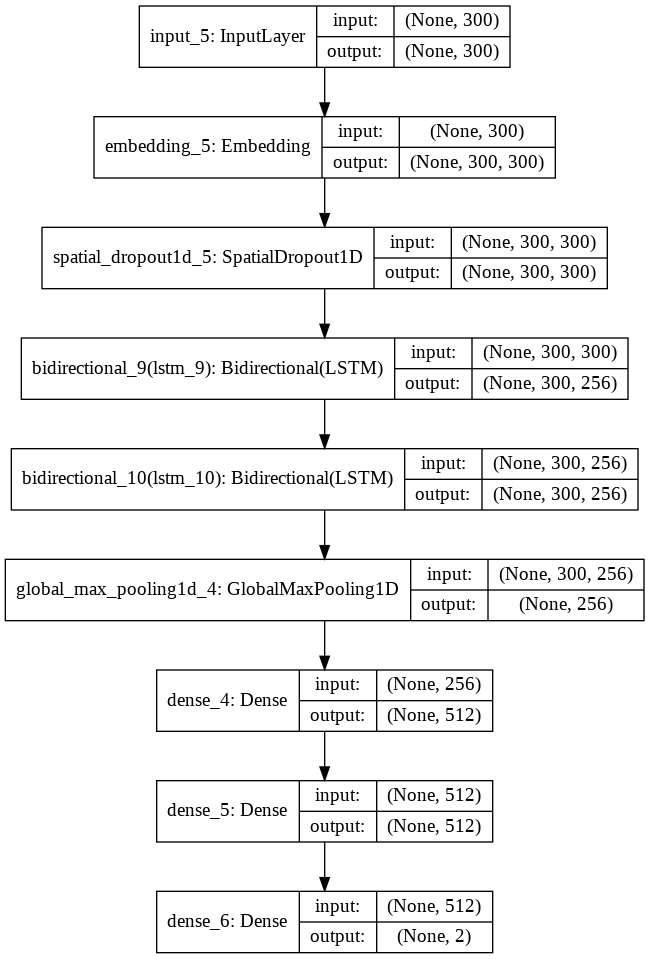

In [0]:
plot_model(model, show_shapes=True, to_file='blstm.png')
Image(filename="blstm.png")

### Defining sample weights for training

In [0]:
# https://www.kaggle.com/kernels/scriptcontent/16109977/download
sample_weights = np.ones(len(train_text), dtype=np.float32)
sample_weights += train_df[identity_columns].sum(axis=1) * 3
sample_weights += train_df[TOXICITY_COLUMN] * (~train_df[identity_columns]).sum(axis=1) * 3
sample_weights += (~train_df[TOXICITY_COLUMN]) * train_df[identity_columns].sum(axis=1) * 9
sample_weights /= sample_weights.mean()

In [0]:
[sample_weights.values, np.ones_like(sample_weights)]

[array([4.29675497, 0.4296755 , 0.4296755 , ..., 0.4296755 , 0.4296755 ,
        0.4296755 ]), array([1., 1., 1., ..., 1., 1., 1.])]

### Model training

In [0]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

W0827 02:36:39.695377 140514143192960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
NUM_EPOCHS = 1

In [0]:
BLSTM_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y),
              sample_weight = [sample_weights.values])

Train on 1263411 samples, validate on 541463 samples
Epoch 1/1
1263411/1263411 [==============================] - 6831s 5ms/step - loss: 0.3101 - acc: 0.8885 - val_loss: 0.2686 - val_acc: 0.8824


### Results

In [0]:
# Prediction on CV data
MODEL_NAME = 'blstm_model'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

In [0]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.897654,0.917810,homosexual_gay_or_lesbian,0.806680,3339
6,0.898438,0.926798,black,0.823255,4402
7,0.901017,0.929039,white,0.830489,7450
5,0.897173,0.933547,muslim,0.840909,6379
4,0.873866,0.961891,jewish,0.885645,2315
8,0.934805,0.921759,psychiatric_or_mental_illness,0.896059,1511
0,0.901376,0.956321,male,0.902366,13383
1,0.895206,0.963688,female,0.909400,16043
3,0.868222,0.974176,christian,0.914691,12194


In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.8872626039756001

### Model training with weighted samples

In [0]:
WBLSTM_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y),
              sample_weight = [sample_weights.values])

W0823 04:08:53.861722 139696546912128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1263411 samples, validate on 541463 samples
Epoch 1/1
1263411/1263411 [==============================] - 7691s 6ms/step - loss: 0.4654 - acc: 0.8748 - val_loss: 0.2780 - val_acc: 0.8935


### Results

In [0]:
# Prediction on CV data
MODEL_NAME = 'blstm_model_weighted'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

In [0]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.853813,0.913659,homosexual_gay_or_lesbian,0.796990,3339
6,0.865050,0.910346,black,0.801441,4402
7,0.882461,0.897098,white,0.807195,7450
5,0.859201,0.921973,muslim,0.818635,6379
8,0.882104,0.921060,psychiatric_or_mental_illness,0.855202,1511
4,0.852695,0.938622,jewish,0.856721,2315
0,0.867118,0.934887,male,0.862123,13383
1,0.864085,0.943800,female,0.875611,16043
3,0.812561,0.968323,christian,0.892188,12194


In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.8883940245291655

## Using GRU and CONV1D + Attention Layer


### Model building

In [0]:
input_text_bgru = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer_bgru = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
g = embedding_layer_bgru(input_text_bgru)
g = SpatialDropout1D(0.4)(g)
g = Bidirectional(GRU(64, return_sequences=True))(g)
att = Attention(MAX_SEQUENCE_LENGTH)(g)
g = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(g)
avg_pool1 = GlobalAveragePooling1D()(g)
max_pool1 = GlobalMaxPooling1D()(g)
g = concatenate([att,avg_pool1, max_pool1])
g = Dense(128, activation='relu')(g)
bgru_output = Dense(2, activation='softmax')(g)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(inputs=[input_text_bgru], outputs=[bgru_output])

### Model visualization

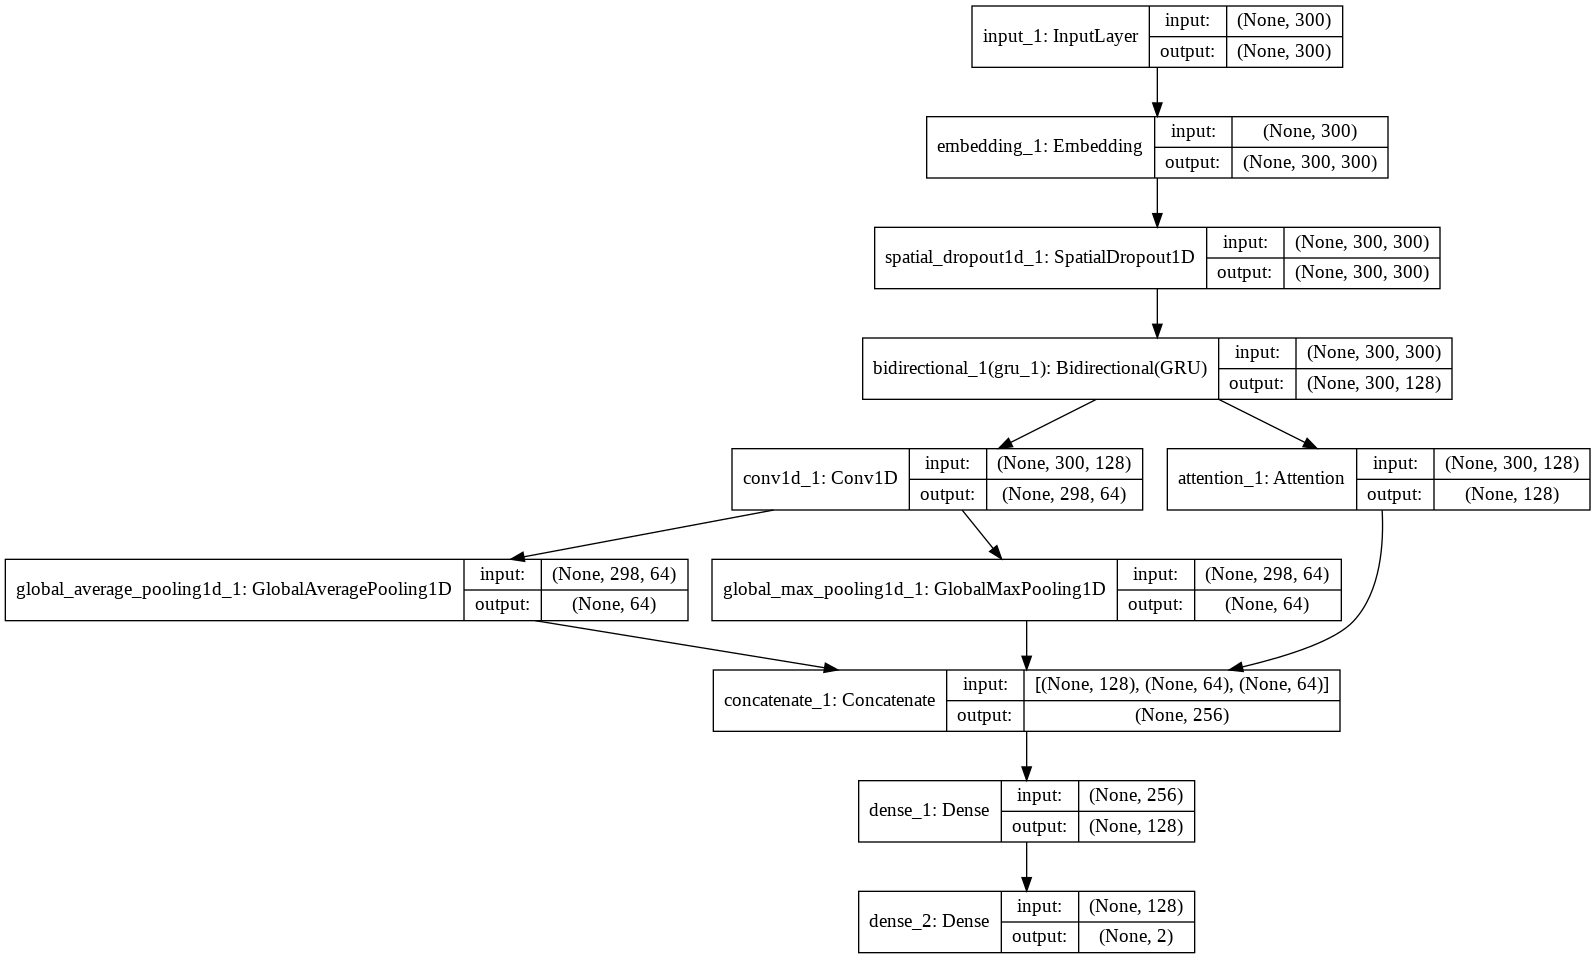

In [0]:
plot_model(model, show_shapes=True, to_file='bgru.png')
Image(filename="bgru.png")

### Model training

In [0]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [0]:
NUM_EPOCHS = 6
BATCH_SIZE = 1300

In [0]:
BGRU_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1443899 samples, validate on 360975 samples
Epoch 1/6
1443899/1443899 [==============================] - 1539s 1ms/step - loss: 0.1592 - acc: 0.9408 - val_loss: 0.1315 - val_acc: 0.9476
Epoch 2/6
1443899/1443899 [==============================] - 1534s 1ms/step - loss: 0.1345 - acc: 0.9476 - val_loss: 0.1334 - val_acc: 0.9458
Epoch 3/6
1443899/1443899 [==============================] - 1535s 1ms/step - loss: 0.1284 - acc: 0.9495 - val_loss: 0.1268 - val_acc: 0.9499
Epoch 4/6
1443899/1443899 [==============================] - 1536s 1ms/step - loss: 0.1255 - acc: 0.9505 - val_loss: 0.1220 - val_acc: 0.9515
Epoch 5/6
1443899/1443899 [==============================] - 1533s 1ms/step - loss: 0.1229 - acc: 0.9512 - val_loss: 0.1261 - val_acc: 0.9486
Epoch 6/6
1443899/1443899 [==============================] - 1526s 1ms/step - loss: 0.1214 - acc: 0.9519 - val_loss: 0.1300 - val_acc: 0.9473


### Results

In [0]:
temp_df = cv_df[:30000]

In [0]:
# Prediction on CV data
MODEL_NAME = 'bgru_model'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

In [0]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.969342,0.835293,homosexual_gay_or_lesbian,0.835027,2249
6,0.974011,0.824891,black,0.849187,2954
7,0.972122,0.839151,white,0.853504,4916
5,0.963826,0.875981,muslim,0.862562,4208
4,0.960670,0.913931,jewish,0.905377,1520
8,0.966532,0.908076,psychiatric_or_mental_illness,0.910110,1043
0,0.963324,0.923137,male,0.919086,8900
1,0.960007,0.929869,female,0.920326,10723
3,0.947801,0.950306,christian,0.927183,8041


In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.9231116803370525

### More dense architecture

In [0]:
input_text_bgru = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer_bgru = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
g = embedding_layer_bgru(input_text_bgru)
g = SpatialDropout1D(0.4)(g)
g = Bidirectional(GRU(128, return_sequences=True))(g)
g = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(g)
avg_pool1 = GlobalAveragePooling1D()(g)
max_pool1 = GlobalMaxPooling1D()(g)
g = concatenate([avg_pool1, max_pool1])
#g = Dense(128, activation='relu')(g)
bgru_output = Dense(2, activation='softmax')(g)

In [0]:
model = Model(inputs=[input_text_bgru], outputs=[bgru_output])

In [0]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [0]:
NUM_EPOCHS = 5
BATCH_SIZE = 1024

In [0]:
BGRU_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y))

Train on 1263411 samples, validate on 541463 samples
Epoch 1/5
1263411/1263411 [==============================] - 1020s 807us/step - loss: 0.1569 - acc: 0.9412 - val_loss: 0.1320 - val_acc: 0.9479
Epoch 2/5
1263411/1263411 [==============================] - 1017s 805us/step - loss: 0.1367 - acc: 0.9469 - val_loss: 0.1272 - val_acc: 0.9492
Epoch 3/5
1263411/1263411 [==============================] - 1017s 805us/step - loss: 0.1305 - acc: 0.9489 - val_loss: 0.1250 - val_acc: 0.9498
Epoch 4/5
1263411/1263411 [==============================] - 1015s 803us/step - loss: 0.1270 - acc: 0.9501 - val_loss: 0.1344 - val_acc: 0.9444
Epoch 5/5
1263411/1263411 [==============================] - 1017s 805us/step - loss: 0.1242 - acc: 0.9510 - val_loss: 0.1289 - val_acc: 0.9471


In [0]:
# Prediction on CV data
MODEL_NAME = 'bgru_model'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

In [0]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.968486,0.825419,homosexual_gay_or_lesbian,0.830983,3339
6,0.975138,0.799232,black,0.836747,4402
7,0.974462,0.810443,white,0.843512,7450
5,0.958109,0.876017,muslim,0.851334,6379
4,0.952885,0.911579,jewish,0.888135,2315
8,0.974656,0.884345,psychiatric_or_mental_illness,0.917721,1511
1,0.962534,0.920187,female,0.919692,16043
0,0.967013,0.911503,male,0.919957,13383
3,0.945040,0.947664,christian,0.924581,12194


In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.9171375219407673

### Conclusion
1. GRU + CONV1D giving us the best score of 0.92311

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "AUC/Designed Metrics AUC"]

x.add_row(["Logistic Regression:", 0.862040])
x.add_row(["CNN1D:", 0.89921])
x.add_row(["Single LSTM:", 0.89822])
x.add_row(["Bi-directional LSTM:", 0.88767])
x.add_row(["Bi-directional LSTM with sample weights:", 0.88839])
x.add_row(["Bi-directional GRU + CONV1D:", 0.92311])
x.add_row(["Bi-directional GRU + CONV1D MORE DENSE:", 0.91713])

print(x)

+------------------------------------------+--------------------------+
|                  Model                   | AUC/Designed Metrics AUC |
+------------------------------------------+--------------------------+
|           Logistic Regression:           |         0.86204          |
|                  CNN1D:                  |         0.89921          |
|               Single LSTM:               |         0.89822          |
|           Bi-directional LSTM:           |         0.88767          |
| Bi-directional LSTM with sample weights: |         0.88839          |
|       Bi-directional GRU + CONV1D:       |         0.92311          |
| Bi-directional GRU + CONV1D MORE DENSE:  |         0.91713          |
+------------------------------------------+--------------------------+
